In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import dataframe_image as dfi
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.stats import loguniform, uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, FrozenEstimator
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display
import shap

In [2]:
#Import Accepted_Only
Accepted_Only_Ord = pd.read_csv('Accepted_Only_OrdEncoded.csv')

In [3]:
Accepted_Only_Ord['Loan_Status'].value_counts()

Loan_Status
1    1025643
0     248165
Name: count, dtype: int64

In [4]:
Accepted_Only_Ord.head()

,Loan_Status,Co-Sign,Term,Grade,Sub_Grade,Risk_Score,Employment_Length,Income_Verification_Status,Income_Annual,Existing_Debt_Payments_Annual,Debt-Income,Installment-Income_Monthly,Loan-Income,Existing_LoanBal-Income,MortgageBal-Income,RevolvingBal-Income,Revolving_Util,OnTime_Payment_%,PastDue-Income,Int_Rate,ROI_loan_amount,ROI_funded_amount,Loan_Amount,Funded_Amount,Return_Total,Principal_Received,Interest_Received,LateFees_Received,Year,Bankruptcies,Chage-Offs_12m,Collections_12m,Delinquencies_>120days_Ever,Delinquencies_>90days_24m,Delinquent_Accounts,Months_since_Delinquency,Credit_Age_inMonths,Credit_Inquiries_12m,Months_since_Revolver_Issued,Months_since_Prior_Loan_Issued,Revolvers_12m,Prior_Loans_12m,Mortgage_Accounts,Home_Ownership,State,Loan_Purpose,Credit_Policy
0,1,0,0,4,21,677,10,0,"55,000","3,250",6,3,7,9,249,5,30,77,0,14,23,23,"3,600","3,600","4,422","3,600",822,0,2015,0,0,0,2,0,0,30,148,4,3,21,3,0,1,MORTGAGE,PA,debt_consolidation,1
1,1,0,0,4,24,717,10,0,"65,000","10,439",16,15,38,28,254,33,19,97,0,12,4,4,"24,700","24,700","25,680","24,700",980,0,2015,0,0,0,0,0,0,6,192,6,2,19,2,0,4,MORTGAGE,SD,small_business,1
2,1,1,1,5,26,697,10,0,"63,000","6,791",11,8,32,17,271,12,56,100,0,11,14,14,"20,000","20,000","22,706","20,000","2,706",0,2015,0,0,0,0,0,0,999,184,1,14,19,0,0,5,MORTGAGE,IL,home_improvement,1
3,1,0,1,1,9,697,3,1,"104,433","26,495",25,3,10,71,226,21,64,97,0,22,13,13,"10,400","10,400","11,740","10,400","1,340",0,2015,0,0,0,0,0,0,12,210,3,4,14,4,0,6,MORTGAGE,PA,major_purchase,1
4,1,0,0,4,22,692,4,1,"34,000","3,468",10,14,35,12,0,26,68,100,0,13,15,15,"11,950","11,950","13,709","11,950","1,759",0,2015,0,0,0,0,0,0,999,338,0,32,338,0,0,0,RENT,GA,debt_consolidation,1


In [4]:
Accepted_Only_Ord = Accepted_Only_Ord.rename(columns={'Risk_Score': 'FICO_Score'})
X_Num_Ord = Accepted_Only_Ord[['Co-Sign', 'Term', 'FICO_Score', 'Employment_Length', 'Debt-Income', 'Installment-Income_Monthly', 'Loan-Income', 'Existing_LoanBal-Income', 'MortgageBal-Income', 'RevolvingBal-Income', 'Revolving_Util', 'OnTime_Payment_%', 'PastDue-Income', 'Int_Rate', 'Bankruptcies', 'Chage-Offs_12m', 'Collections_12m', 'Delinquencies_>120days_Ever', 'Delinquencies_>90days_24m', 'Delinquent_Accounts', 'Months_since_Delinquency', 'Credit_Age_inMonths', 'Credit_Inquiries_12m', 'Months_since_Revolver_Issued', 'Months_since_Prior_Loan_Issued', 'Revolvers_12m', 'Prior_Loans_12m', 'Mortgage_Accounts']].apply(pd.to_numeric, errors='coerce')
X_Nominal = Accepted_Only_Ord[['Home_Ownership', 'Loan_Purpose']].astype('category')
Y = Accepted_Only_Ord['Loan_Status']

In [5]:
#One Hot Encode Nominal (State).  #Initially tried to incorporate state but am now dropping State completely for efficiency
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_Nominal_One_Hot = encoder.fit_transform(X_Nominal)
X_Nominal_One_Hot_df = pd.DataFrame(
    X_Nominal_One_Hot,
    columns=encoder.get_feature_names_out(X_Nominal.columns),
    index=Accepted_Only_Ord.index
)
#Merge
X = pd.merge(
    X_Num_Ord,
    X_Nominal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)

#for models that natively handle nominal
X2 = pd.merge(  
    X_Num_Ord,
    X_Nominal,
    left_index=True,
    right_index=True,
    how='left'
)

In [7]:
X.shape

(1273808, 45)

In [8]:
X2.shape

(1273808, 30)

In [9]:
X.head()

,Co-Sign,Term,FICO_Score,Employment_Length,Debt-Income,Installment-Income_Monthly,Loan-Income,Existing_LoanBal-Income,MortgageBal-Income,RevolvingBal-Income,Revolving_Util,OnTime_Payment_%,PastDue-Income,Int_Rate,Bankruptcies,Chage-Offs_12m,Collections_12m,Delinquencies_>120days_Ever,Delinquencies_>90days_24m,Delinquent_Accounts,Months_since_Delinquency,Credit_Age_inMonths,Credit_Inquiries_12m,Months_since_Revolver_Issued,Months_since_Prior_Loan_Issued,Revolvers_12m,Prior_Loans_12m,Mortgage_Accounts,Home_Ownership_MORTGAGE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,Loan_Purpose_credit_card,Loan_Purpose_debt_consolidation,Loan_Purpose_educational,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding
0,0,0,677,10,6,3,7,9,249,5,30,77,0,14,0,0,0,2,0,0,30,148,4,3,21,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,717,10,16,15,38,28,254,33,19,97,0,12,0,0,0,0,0,0,6,192,6,2,19,2,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1,697,10,11,8,32,17,271,12,56,100,0,11,0,0,0,0,0,0,999,184,1,14,19,0,0,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,697,3,25,3,10,71,226,21,64,97,0,22,0,0,0,0,0,0,12,210,3,4,14,4,0,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,692,4,10,14,35,12,0,26,68,100,0,13,0,0,0,0,0,0,999,338,0,32,338,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
X2.head()

,Co-Sign,Term,FICO_Score,Employment_Length,Debt-Income,Installment-Income_Monthly,Loan-Income,Existing_LoanBal-Income,MortgageBal-Income,RevolvingBal-Income,Revolving_Util,OnTime_Payment_%,PastDue-Income,Int_Rate,Bankruptcies,Chage-Offs_12m,Collections_12m,Delinquencies_>120days_Ever,Delinquencies_>90days_24m,Delinquent_Accounts,Months_since_Delinquency,Credit_Age_inMonths,Credit_Inquiries_12m,Months_since_Revolver_Issued,Months_since_Prior_Loan_Issued,Revolvers_12m,Prior_Loans_12m,Mortgage_Accounts,Home_Ownership,Loan_Purpose
0,0,0,677,10,6,3,7,9,249,5,30,77,0,14,0,0,0,2,0,0,30,148,4,3,21,3,0,1,MORTGAGE,debt_consolidation
1,0,0,717,10,16,15,38,28,254,33,19,97,0,12,0,0,0,0,0,0,6,192,6,2,19,2,0,4,MORTGAGE,small_business
2,1,1,697,10,11,8,32,17,271,12,56,100,0,11,0,0,0,0,0,0,999,184,1,14,19,0,0,5,MORTGAGE,home_improvement
3,0,1,697,3,25,3,10,71,226,21,64,97,0,22,0,0,0,0,0,0,12,210,3,4,14,4,0,6,MORTGAGE,major_purchase
4,0,0,692,4,10,14,35,12,0,26,68,100,0,13,0,0,0,0,0,0,999,338,0,32,338,0,0,0,RENT,debt_consolidation


In [6]:
#Train Test Split X
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=2)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=.2, stratify=Y_train, random_state=2)

#Scale numeric features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
#Train Test Split X2
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, test_size=.2, stratify=Y, random_state=2)
X2_tr, X2_val, Y2_tr, Y2_val = train_test_split(X2_train, Y2_train, test_size=.2, stratify=Y2_train, random_state=2)

#Nominal feature indices
cat_feature_indices = [X2_tr.columns.get_loc(col) for col in X_Nominal.columns]

In [13]:
Accepted_Only_Ord['Loan_Status'].value_counts()

Loan_Status
1    1025643
0     248165
Name: count, dtype: int64

In [8]:
#Scale Positive Weight
neg = (Y2_train == 0).sum()
pos = (Y2_train == 1).sum()
spw = pos / neg    #reversed since 0 is now the minority class
print('scale_pos_weight =', spw)

#for XGboost
weights = compute_sample_weight('balanced', Y2_tr)

scale_pos_weight = 4.132905526564987


In [15]:
#Logistic Regression (Base)
logreg = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    penalty='l2',
    n_jobs=-1,
    tol=1e-3
)

logreg.fit(X_tr_scaled, Y_tr)

logreg_val_auc = roc_auc_score(Y_val, logreg.predict_proba(X_val_scaled)[:, 1])
logreg_test_auc = roc_auc_score(Y_test, logreg.predict_proba(X_test_scaled)[:, 1])

print('Logistic Regression Validation ROC-AUC:', logreg_val_auc)
print('Logistic Regression Test ROC-AUC:', logreg_test_auc)

Logistic Regression Validation ROC-AUC: 0.7132426974290884
Logistic Regression Test ROC-AUC: 0.7119889329212723


In [17]:
#Logistic Regression (Randomized Search CV)
logreg_param_dist = {'C': loguniform(1e-4, 1e2)}

logreg_randCV = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=logreg_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    random_state=5,
    n_jobs=-1,
    error_score= np.nan
)

#Fit on scaled subsample
logreg_randCV.fit(X_tr_scaled, Y_tr)
print('Logistic Regression Best Parameters:', logreg_randCV.best_params_)

Logistic Regression Best Parameters: {'C': np.float64(19.03803790659403)}


In [18]:
#Refit Logistic Regression Best Parameters on full training data
logreg_best = logreg_randCV.best_estimator_
logreg_best.fit(X_tr_scaled, Y_tr)

#Evaluate
logreg_best_val_auc = roc_auc_score(Y_val, logreg_best.predict_proba(X_val_scaled)[:, 1])
logreg_best_test_auc = roc_auc_score(Y_test, logreg_best.predict_proba(X_test_scaled)[:, 1])

print('Logistic Regression Validation AUC (Best):', logreg_best_val_auc)
print('Logistic Regression Test AUC (Best):', logreg_best_test_auc)

Logistic Regression Validation AUC (Best): 0.7132427964156226
Logistic Regression Test AUC (Best): 0.7119890241681734


In [19]:
#SGD Classifier (Base)
sgd_lr = SGDClassifier(
    loss='log_loss',
    class_weight='balanced',
    max_iter=10,
    n_jobs=-1,
    tol=1e-3,
    learning_rate='optimal'
)

sgd_lr.fit(X_tr_scaled, Y_tr)

sgd_val_auc = roc_auc_score(Y_val, sgd_lr.predict_proba(X_val_scaled)[:, 1])
sgd_test_auc = roc_auc_score(Y_test, sgd_lr.predict_proba(X_test_scaled)[:, 1])

print('SGD Classifier Validation AUC:', sgd_val_auc)
print('SGD Classifier Test AUC:', sgd_test_auc)

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD Classifier Validation AUC: 0.7079521656754362
SGD Classifier Test AUC: 0.7055955671313232


In [20]:
#SGD Classifier Regression (Randomized Search CV)
sgd_param_dist = {
    'alpha': uniform(1e-5, 1e-2),
    'max_iter': randint(5, 50),
    'learning_rate': ['optimal', 'invscaling', 'constant'],
    'eta0': uniform(0.001, 0.1),
    'power_t': uniform(0.1, 0.9)
}

sgd_randCV = RandomizedSearchCV(
    estimator=sgd_lr,
    param_distributions=sgd_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

sgd_randCV.fit(X_tr_scaled, Y_tr)
sgd_best = sgd_randCV.best_estimator_
print('SGD Classifier Best Parameters:', sgd_randCV.best_params_)

SGD Classifier Best Parameters: {'alpha': np.float64(0.009841534453572127), 'eta0': np.float64(0.045135491935484676), 'learning_rate': 'invscaling', 'max_iter': 20, 'power_t': np.float64(0.598270456744509)}


In [21]:
#SGD Classifier Regression Best Parameters on full training data
sgd_best.fit(X_tr_scaled, Y_tr)

# Evaluate
sgd_best_val_auc = roc_auc_score(Y_val, sgd_best.predict_proba(X_val_scaled)[:, 1])
sgd_best_test_auc = roc_auc_score(Y_test, sgd_best.predict_proba(X_test_scaled)[:, 1])

print('SGD Classifier Validation AUC (Best):', sgd_best_val_auc)
print('SGD Classifier Test AUC (Best):', sgd_best_test_auc)

SGD Classifier Validation AUC (Best): 0.7131441476634732
SGD Classifier Test AUC (Best): 0.7118865022340335


In [22]:
#Decision Tree (Base)
dt = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    random_state=2,
    class_weight='balanced',
)

dt.fit(X_tr, Y_tr)

dt_val_preds = dt.predict_proba(X_val)[:, 1]
dt_test_preds = dt.predict_proba(X_test)[:, 1]

dt_val_auc = roc_auc_score(Y_val, dt_val_preds)
dt_test_auc = roc_auc_score(Y_test, dt_test_preds)

print('Decision Tree Validation AUC:', dt_val_auc)
print('Decision Tree Test AUC:', dt_test_auc)

Decision Tree Validation AUC: 0.5486881481070518
Decision Tree Test AUC: 0.5475213161495628


In [23]:
#Decision Tree (Randomized Search CV)
dt_param_dist = {
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 100),
    'min_samples_leaf': randint(1, 50),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

dt_randCV = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

dt_randCV.fit(X_tr, Y_tr)
print('Decision Tree Best Parameters:', dt_randCV.best_params_)

Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 43, 'min_samples_split': 53}


In [24]:
#Refit Decision Tree Best Parameters on full training set
dt_best = dt_randCV.best_estimator_
dt_best.fit(X_train, Y_train)

dt_best_val_preds = dt_best.predict_proba(X_val)[:, 1]
dt_best_test_preds = dt_best.predict_proba(X_test)[:, 1]

dt_best_val_auc = roc_auc_score(Y_val, dt_best_val_preds)
dt_best_test_auc = roc_auc_score(Y_test, dt_best_test_preds)

print('Decision Tree Validation AUC (Best):', dt_best_val_auc)
print('Decision Tree Test AUC (Best):', dt_best_test_auc)

Decision Tree Validation AUC (Best): 0.7155560160306811
Decision Tree Test AUC (Best): 0.7072844205201757


In [25]:
#Hist Gradient Boosting (Base)
hgb = HistGradientBoostingClassifier(random_state=2, class_weight='balanced', categorical_features=cat_feature_indices)

hgb.fit(X2_tr, Y2_tr)

hgb_val_preds = hgb.predict_proba(X2_val)[:, 1]
hgb_test_preds = hgb.predict_proba(X2_test)[:, 1]

hgb_val_auc = roc_auc_score(Y2_val, hgb_val_preds)
hgb_test_auc = roc_auc_score(Y2_test, hgb_test_preds)

print('HistGradientBoosting Validation AUC:', hgb_val_auc)
print('HistGradientBoosting Test AUC:', hgb_test_auc)

HistGradientBoosting Validation AUC: 0.7231132033664112
HistGradientBoosting Test AUC: 0.7223243909006576


In [26]:
#Hist Gradient Boosting (Randomized Search CV)
hgb_param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_leaf': randint(10, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_iter': randint(100, 300),
    'max_bins': randint(2, 256)
}
hgb_randCV = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=hgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

hgb_randCV.fit(X2_tr, Y2_tr)
print('Best Parameters:', hgb_randCV.best_params_)

Best Parameters: {'learning_rate': np.float64(0.08737797706415248), 'max_bins': 65, 'max_depth': 18, 'max_iter': 248, 'min_samples_leaf': 160}


In [27]:
#Refit Hist Gradient Boosting Best Parameters on full training set
hgb_best = hgb_randCV.best_estimator_
hgb_best.fit(X2_tr, Y2_tr)

hgb_best_val_preds = hgb_best.predict_proba(X2_val)[:, 1]
hgb_best_test_preds = hgb_best.predict_proba(X2_test)[:, 1]

hgb_best_val_auc = roc_auc_score(Y2_val, hgb_best_val_preds)
hgb_best_test_auc = roc_auc_score(Y2_test, hgb_best_test_preds)

print('HistGradientBoosting Validation AUC (Best):', hgb_best_val_auc)
print('HistGradientBoosting Test AUC (Best):', hgb_best_test_auc)

HistGradientBoosting Validation AUC (Best): 0.7248076923032949
HistGradientBoosting Test AUC (Best): 0.7236938531244148


In [9]:
#LightGBM Base Model (w scale_pos_weight)
lgb = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    class_weight={0: spw, 1: 1.0},
    random_state=2,
    n_jobs=-1
)

lgb.fit(X2_tr, Y2_tr, categorical_feature=list(X_Nominal.columns))

lgb_val_preds = lgb.predict_proba(X2_val)[:, 1]
lgb_test_preds = lgb.predict_proba(X2_test)[:, 1]

lgb_val_auc = roc_auc_score(Y2_val, lgb_val_preds)
lgb_test_auc = roc_auc_score(Y2_test, lgb_test_preds)

print('LightGBM Validation AUC (Base):', lgb_val_auc)
print('LightGBM Test AUC (Base):', lgb_test_auc)

[LightGBM] [Info] Number of positive: 656411, number of negative: 158825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 815236, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
LightGBM Validation AUC (Base): 0.7234668113507869
LightGBM Test AUC (Base): 0.722795704571315


In [13]:
#Randomized Search CV

#Initial Search range, no longer needed in later model reloads
'''
lgb_param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.1),
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 10),
    'min_child_samples': randint(50, 300),
    'subsample': uniform(0.6, 0.3),
    'colsample_bytree': uniform(0.6, 0.3),
    'reg_alpha': uniform(0.0, 0.5),
    'reg_lambda': uniform(0.0, 0.5),
}
'''
#Optimal Parameters found by Randomized Search range above
lgb_param_dist = {
    'n_estimators': [443],
    'learning_rate': [0.0531537770235124],
    'num_leaves': [63],
    'max_depth': [7],
    'min_child_samples': [268],
    'subsample': [0.8294879581355044],
    'colsample_bytree': [0.8239894224267689],
    'reg_alpha': [0.4001291755662934],
    'reg_lambda': [0.3009085607027337],
}

lgb_randCV = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

lgb_randCV.fit(X2_tr, Y2_tr)
print('Best Parameters:', lgb_randCV.best_params_)

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=25. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 656411, number of negative: 158825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 815236, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [11]:
#Refit Best Parameters on Full Training Set
lgb_best = lgb_randCV.best_estimator_

#Ensure scale_pos_weight is still applied
lgb_best.set_params(class_weight={0: spw, 1: 1.0})

lgb_best.fit(X2_tr, Y2_tr, categorical_feature=list(X_Nominal.columns))

lgb_best_val_auc = roc_auc_score(Y2_val, lgb_best.predict_proba(X2_val)[:, 1])
lgb_best_test_auc = roc_auc_score(Y2_test, lgb_best.predict_proba(X2_test)[:, 1])

print('LightGBM Validation AUC (Best):', lgb_best_val_auc)
print('LightGBM Test AUC (Best):', lgb_best_test_auc)

[LightGBM] [Info] Number of positive: 656411, number of negative: 158825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 815236, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [31]:
#XGBoost (Base)
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
    random_state=2,
    enable_categorical=True
)

xgb.fit(X2_tr, Y2_tr, sample_weight=weights)

xgb_val_preds = xgb.predict_proba(X2_val)[:, 1]
xgb_test_preds = xgb.predict_proba(X2_test)[:, 1]

xgb_val_auc = roc_auc_score(Y2_val, xgb_val_preds)
xgb_test_auc = roc_auc_score(Y2_test, xgb_test_preds)

print('XGBoost Base Validation AUC:', xgb_val_auc)
print('XGBoost Base Test AUC:', xgb_test_auc)

XGBoost Base Validation AUC: 0.7226306291263008
XGBoost Base Test AUC: 0.721807460851246


In [32]:
#XGBoost (Randomized Search CV)
xgb_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 20)
}

xgb_randCV = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

xgb_randCV.fit(X2_tr, Y2_tr)
print('Best Parameters:', xgb_randCV.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.8060556483455749), 'learning_rate': np.float64(0.054199630658630066), 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 196, 'subsample': np.float64(0.9553214996869922)}


In [33]:
#Refit XGBoost Best Parameters on full training set
xgb_best = xgb_randCV.best_estimator_

xgb_best.fit(X2_tr, Y2_tr, sample_weight=weights)

xgb_best_val_auc = roc_auc_score(Y2_val, xgb_best.predict_proba(X2_val)[:, 1])
xgb_best_test_auc = roc_auc_score(Y2_test, xgb_best.predict_proba(X2_test)[:, 1])

print('XGBoost Validation AUC (Best):', xgb_best_val_auc)
print('XGBoost Test AUC (Best):', xgb_best_test_auc)

XGBoost Validation AUC (Best): 0.7247491855833412
XGBoost Test AUC (Best): 0.7235248912668013


In [34]:
#CatBoost (Base)
cat = CatBoostClassifier(eval_metric='AUC', class_weights=[spw, 1], random_seed=2, thread_count=-1, verbose=0,
                        cat_features=[col for col in X_Nominal.columns])

cat.fit(X2_tr, Y2_tr, eval_set=(X2_val, Y2_val), cat_features=list(X_Nominal.columns))

cat_val_preds = cat.predict_proba(X2_val)[:, 1]
cat_test_preds = cat.predict_proba(X2_test)[:, 1]

cat_val_auc = roc_auc_score(Y2_val, cat_val_preds)
cat_test_auc = roc_auc_score(Y2_test, cat_test_preds)

print('CatBoost Base Validation AUC:', cat_val_auc)
print('CatBoost Base Test AUC:', cat_test_auc)

CatBoost Base Validation AUC: 0.7262518969347768
CatBoost Base Test AUC: 0.7255186393008044


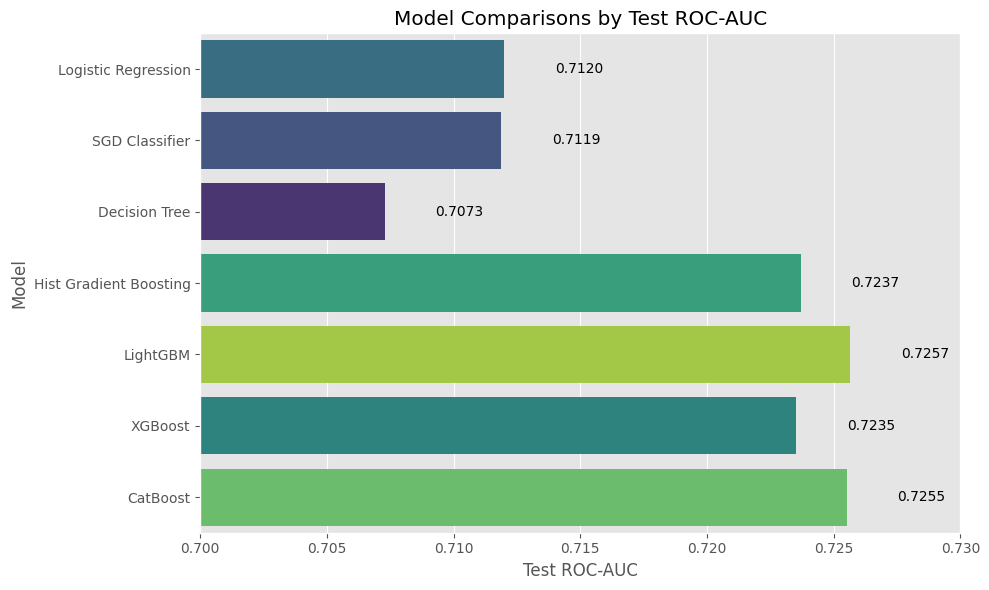

In [36]:
#Bar Plot Comparison of All Scores
model_best_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'SGD Classifier', 'Decision Tree', 'Hist Gradient Boosting', 'LightGBM', 'XGBoost', 'CatBoost'],
    'Test_AUC': [logreg_best_test_auc, sgd_best_test_auc, dt_best_test_auc, hgb_best_test_auc, lgb_best_test_auc, xgb_best_test_auc, cat_test_auc]})

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Test_AUC',
    y='Model',
    data=model_best_scores,
    hue=model_best_scores['Test_AUC'],
    palette=sns.color_palette('viridis', n_colors=len(model_best_scores)),
    legend=False
)
plt.xlabel('Test ROC-AUC')
plt.title('Model Comparisons by Test ROC-AUC')
plt.xlim(0.7, 0.73)
for index, row in model_best_scores.iterrows():
    plt.text(row.Test_AUC + 0.002, index, f'{row.Test_AUC:.4f}', va='center')
plt.tight_layout()
plt.show()

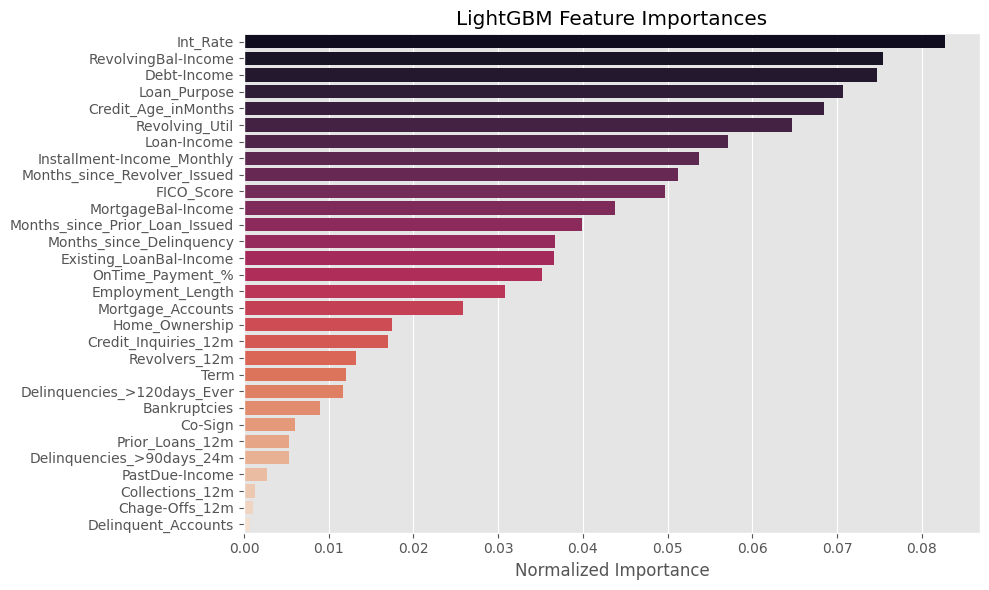

In [39]:
#Normalized Feature Importances for Top Model (LightGBM)

feature_importances = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': lgb_best.feature_importances_
})

#Normalize (total sums to 1)
feature_importances['Importance'] = feature_importances['Importance'] / feature_importances['Importance'].sum()

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances,
    hue=feature_importances['Importance'],
    palette=sns.color_palette('rocket', n_colors=len(feature_importances))[::-1],
    dodge=False,
    legend=False
)
plt.title('LightGBM Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

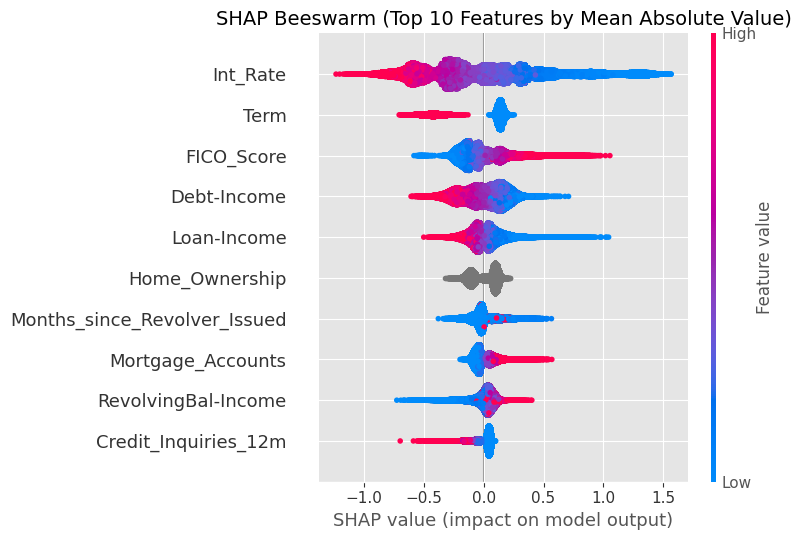

In [16]:
#---SHAP Beeswarm (Top 10)
'''
#SHAP values
explainer = shap.TreeExplainer(lgb_best)
shap_values = explainer.shap_values(X2_test)

sv = shap_values if isinstance(shap_values, np.ndarray) else shap_values[1]

#Top 10 features by mean SHAP (abs value)
mean_abs_shap = np.abs(sv).mean(axis=0)
top10_idx = np.argsort(mean_abs_shap)[-10:]
X2_test_top10 = X2_test.iloc[:, top10_idx]
sv_top10 = sv[:, top10_idx]
'''
#Beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(sv_top10, X2_test_top10, plot_type='dot', show=False)

plt.title('SHAP Beeswarm (Top 10 Features by Mean Absolute Value)', fontsize=14)
plt.tight_layout()
plt.show()

Model classes order: [np.int64(0), np.int64(1)]
Predicted label counts (after using prob for class 1):
 1    151129
0    103633
Name: count, dtype: int64

Actual label counts (Y_test):
 Loan_Status
1    205129
0     49633
Name: count, dtype: int64


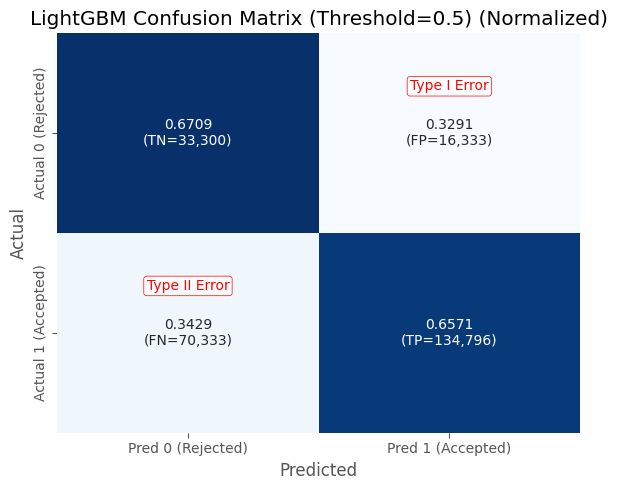

TN= 33,300  FP= 16,333 
FN= 70,333  TP= 134,796
Accuracy:    0.6598
Precision:   0.8919
Recall:      0.6571
Specificity: 0.6709
F1 Score:    0.7567
Kappa:       0.2323
Type I Error (FP Rate):  0.3291
Type II Error (FN Rate): 0.3429


In [42]:
#---Confusion Matrix & Metrics

#Check prediction distribution
pd.Series(lgb_best.predict(X2_test)).value_counts(normalize=True)

probs_all = lgb_best.predict_proba(X2_test)
classes_order = list(lgb_best.classes_)
print('Model classes order:', classes_order)

#index and prob of positive class
try:
    try:
        numeric_classes = [int(c) for c in classes_order]
        idx_pos = numeric_classes.index(1)
    except:
        raise ValueError(f'Model classes {classes_order} cannot be mapped to 0 or 1')
except ValueError:
    raise ValueError('Class 1 not found in model.classes_. Y_train/Y_test labels')

lgb_best_test_probs_for_1 = probs_all[:, idx_pos]

#threshold, predictions
threshold = 0.5
lgb_best_test_preds = (lgb_best_test_probs_for_1 >= threshold).astype(int)

#sanity counts
print('Predicted label counts (after using prob for class 1):\n', pd.Series(lgb_best_test_preds).value_counts())
print('\nActual label counts (Y_test):\n', pd.Series(Y2_test).value_counts())

#Confusion Matrix
cm = confusion_matrix(Y2_test, lgb_best_test_preds, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

type1_error = FP / (FP + TN) if (FP + TN) > 0 else np.nan
type2_error = FN / (FN + TP) if (FN + TP) > 0 else np.nan

cm_df = pd.DataFrame(cm_norm,
                     index=['Actual 0 (Rejected)', 'Actual 1 (Accepted)'],
                     columns=['Pred 0 (Rejected)', 'Pred 1 (Accepted)'])
annot_labels = np.array([
    [f'{cm_norm[0,0]:.4f}\n(TN={TN:,})', f'{cm_norm[0,1]:.4f}\n(FP={FP:,})'],
    [f'{cm_norm[1,0]:.4f}\n(FN={FN:,})', f'{cm_norm[1,1]:.4f}\n(TP={TP:,})']
])

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    cm_df,
    annot=annot_labels,
    fmt='',
    cmap='Blues',
    cbar=False
)

#Type I Error Label
ax.text(
    1 + .5, 0 + .3,
    'Type I Error',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

#Type II Error Label
ax.text(
    0 + 0.5, 1 + 0.3,
    'Type II Error',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

plt.title(f'LightGBM Confusion Matrix (Threshold={threshold}) (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Metrics
accuracy    = accuracy_score(Y2_test, lgb_best_test_preds)
precision   = precision_score(Y2_test, lgb_best_test_preds, pos_label=1)
recall      = recall_score(Y2_test, lgb_best_test_preds, pos_label=1)
specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
f1          = f1_score(Y2_test, lgb_best_test_preds, pos_label=1)
kappa       = cohen_kappa_score(Y2_test, lgb_best_test_preds)

print(f'TN= {TN:,}  FP= {FP:,} \nFN= {FN:,}  TP= {TP:,}')
print(f'Accuracy:    {accuracy:.4f}')
print(f'Precision:   {precision:.4f}')
print(f'Recall:      {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score:    {f1:.4f}')
print(f'Kappa:       {kappa:.4f}')
print(f'Type I Error (FP Rate):  {type1_error:.4f}')
print(f'Type II Error (FN Rate): {type2_error:.4f}')

In [110]:
#---Compute All Metrics, Best Model by Accuracy
models = {
    'Logistic' : logreg_best,
    'SGD'      : sgd_best,
    'HistGB'   : hgb_best,
    'LightGBM' : lgb_best,
    'XGBoost'  : xgb_best,
    'CatBoost' : cat
}

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

rows = []
for name, mdl in models.items():
    if name in ['Logistic', 'SGD']:
        X_input = X_test_scaled  # scaled

        # predicted probabilities
        try:
            probs = mdl.predict_proba(X_input)[:,1]
        except Exception:
            probs = None
    
        y_pred = (probs >= 0.5).astype(int) if probs is not None else mdl.predict(X_input)
    
        tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
        acc = accuracy_score(Y_test, y_pred)
        bal_acc = balanced_accuracy_score(Y_test, y_pred)
        prec = precision_score(Y_test, y_pred, zero_division=0)
        rec = recall_score(Y_test, y_pred, zero_division=0)
        spec = specificity_score(Y_test, y_pred)
        f1 = f1_score(Y_test, y_pred, zero_division=0)
        kappa = cohen_kappa_score(Y_test, y_pred)
        roc = roc_auc_score(Y_test, probs) if probs is not None else np.nan
        prec_val, rec_val, _ = precision_recall_curve(Y_test, probs) if probs is not None else (np.nan, np.nan, np.nan)
        pr_auc = auc(rec_val, prec_val) if probs is not None else np.nan
        brier = brier_score_loss(Y_test, probs) if probs is not None else np.nan
    
    else:
        X_input = X2_test 

        try:
            probs = mdl.predict_proba(X_input)[:,1]
        except Exception:
            probs = None
    
        y_pred = (probs >= 0.5).astype(int) if probs is not None else mdl.predict(X_input)
        
        tn, fp, fn, tp = confusion_matrix(Y2_test, y_pred).ravel()
        acc = accuracy_score(Y2_test, y_pred)
        bal_acc = balanced_accuracy_score(Y2_test, y_pred)
        prec = precision_score(Y2_test, y_pred, zero_division=0)
        rec = recall_score(Y2_test, y_pred, zero_division=0)
        spec = specificity_score(Y2_test, y_pred)
        f1 = f1_score(Y2_test, y_pred, zero_division=0)
        kappa = cohen_kappa_score(Y2_test, y_pred)
        roc = roc_auc_score(Y2_test, probs) if probs is not None else np.nan
        prec_val, rec_val, _ = precision_recall_curve(Y2_test, probs) if probs is not None else (np.nan, np.nan, np.nan)
        pr_auc = auc(rec_val, prec_val) if probs is not None else np.nan
        brier = brier_score_loss(Y2_test, probs) if probs is not None else np.nan

    rows.append({
        'Model': name,
        'Accuracy': acc,
        'Balanced Accuracy': bal_acc,
        'Precision': prec,
        'Recall': rec,
        'Specificity': spec,
        'F1': f1,
        'Kappa': kappa,
        'ROC_AUC': roc,
        'PR_AUC': pr_auc,
        'Brier': brier,
        'TP': f'{tp:,}',
        'TN': f'{tn:,}',
        'FP': f'{fp:,}',
        'FN': f'{fn:,}'
        
    })

df = pd.DataFrame(rows).set_index('Model').sort_values('Accuracy', ascending=False)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print('--- Metrics sorted by Accuracy (threshold 0.5) ---')
display(df)

#Summary- best by accuracy & balanced accuracy
best_by_acc = df['Accuracy'].idxmax()
best_by_balacc = df['Balanced Accuracy'].idxmax()
print(f"Best model by ACC (0.5):     {best_by_acc} (accuracy={df.loc[best_by_acc,'Accuracy']:.4f})")
print(f"Best model by BAL_ACC (0.5): {best_by_balacc} (balanced accuracy={df.loc[best_by_balacc,'Balanced Accuracy']:.4f})")

--- Metrics sorted by Accuracy (threshold 0.5) ---


,Accuracy,Balanced Accuracy,Precision,Recall,Specificity,F1,Kappa,ROC_AUC,PR_AUC,Brier,TP,TN,FP,FN
Model,,,,,,,,,,,,,,
CatBoost,0.9784,0.9662,0.9413,0.9465,0.9860,0.9439,0.9305,0.9964,0.9820,0.0163,"400,118","1,753,312","24,969","22,601"
XGBoost,0.9741,0.9608,0.9271,0.9392,0.9824,0.9331,0.9171,0.9952,0.9764,0.0196,"397,022","1,747,069","31,212","25,697"
HistGB,0.9718,0.9562,0.9230,0.9308,0.9815,0.9269,0.9094,0.9942,0.9714,0.0216,"393,475","1,745,442","32,839","29,244"
LightGBM,0.9705,0.9781,0.8730,0.9904,0.9657,0.9280,0.9095,0.9965,0.9823,0.0204,"418,670","1,717,350","60,931","4,049"
DecisionTree,0.9690,0.9559,0.9066,0.9348,0.9771,0.9205,0.9012,0.9923,0.9632,0.0241,"395,155","1,737,564","40,717","27,564"
SGD,0.8786,0.8618,0.6412,0.8345,0.8890,0.7252,0.6490,0.9415,0.7430,0.0983,"352,767","1,580,923","197,358","69,952"
Logistic,0.8759,0.8626,0.6331,0.8410,0.8842,0.7224,0.6445,0.9411,0.7419,0.0979,"355,492","1,572,292","205,989","67,227"


Best model by ACC (0.5):     CatBoost (accuracy=0.9784)
Best model by BAL_ACC (0.5): LightGBM (balanced accuracy=0.9781)


Optimal Threshold (Youden's J): 0.51
TN=34,294 FP=15,339 FN=74,569 TP=130,560
Accuracy:    0.6471
Precision:   0.8949
Recall:      0.6365
Specificity: 0.6910
F1 Score:    0.7439


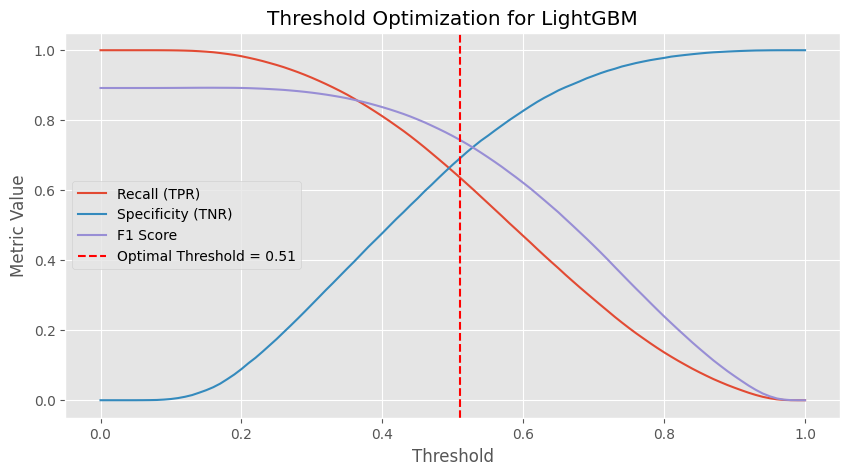

In [43]:
#---Optimal Threshold (Youden's J = TPR + TNR - 1)

lgb_best_test_probs = cat.predict_proba(X2_test)[:, 1]

thresholds = np.linspace(0, 1, 101)

results = []

for t in thresholds:
    preds = (lgb_best_test_probs >= t).astype(int)
    cm = confusion_matrix(Y2_test, preds, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    
    accuracy    = (TP + TN) / (TP + TN + FP + FN)
    precision   = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall      = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1          = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': t,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    })

results_df = pd.DataFrame(results)

#Youden's J
results_df['youden_j'] = results_df['recall'] + results_df['specificity'] - 1
best_idx = results_df['youden_j'].idxmax()
best_threshold = results_df.loc[best_idx, 'threshold']

print("Optimal Threshold (Youden's J):", best_threshold)

lgb_best_test_preds_opt = (lgb_best_test_probs >= best_threshold).astype(int)

#Confusion Matrix & Metrics
cm = confusion_matrix(Y2_test, lgb_best_test_preds_opt, labels=[0,1])
TN, FP, FN, TP = cm.ravel()

print(f'TN={TN:,} FP={FP:,} FN={FN:,} TP={TP:,}')

accuracy    = (TP + TN) / (TP + TN + FP + FN)
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
specificity = TN / (TN + FP)
f1          = 2 * precision * recall / (precision + recall)

print(f'Accuracy:    {accuracy:.4f}')
print(f'Precision:   {precision:.4f}')
print(f'Recall:      {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score:    {f1:.4f}')

plt.figure(figsize=(10,5))
plt.plot(results_df['threshold'], results_df['recall'], label='Recall (TPR)')
plt.plot(results_df['threshold'], results_df['specificity'], label='Specificity (TNR)')
plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold Optimization for LightGBM')
plt.legend()
plt.grid(True)
plt.show()

Optimal Threshold (Max Precision): 0.98
TN=49,633 FP=0 FN=205,098 TP=31
Accuracy:    0.1949
Precision:   1.0000
Recall:      0.0002
Specificity: 1.0000
F1 Score:    0.0003


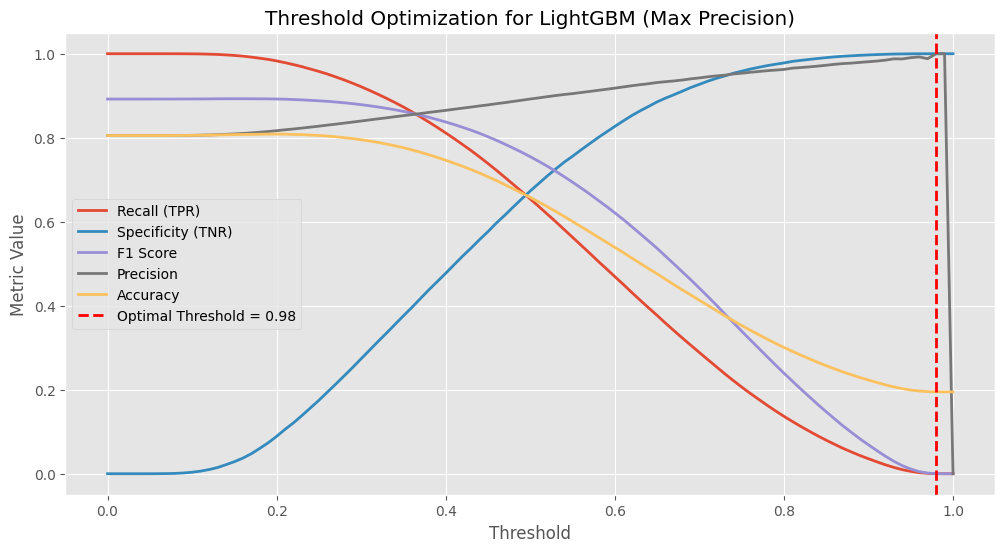

In [44]:
#---Optimal Threshold for Precision

lgb_best_test_probs = cat.predict_proba(X2_test)[:, 1]
thresholds = np.linspace(0, 1, 101)

results = []

for t in thresholds:
    preds = (lgb_best_test_probs >= t).astype(int)
    cm = confusion_matrix(Y2_test, preds, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    
    accuracy    = (TP + TN) / (TP + TN + FP + FN)
    precision   = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall      = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1          = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': t,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    })

results_df = pd.DataFrame(results)

#Select threshold that maximizes precision
best_idx = results_df['precision'].idxmax()
best_threshold = results_df.loc[best_idx, 'threshold']

print('Optimal Threshold (Max Precision):', best_threshold)

#Apply threshold
lgb_best_test_preds_opt = (lgb_best_test_probs >= best_threshold).astype(int)

#Confusion Matrix & Metrics
cm = confusion_matrix(Y2_test, lgb_best_test_preds_opt, labels=[0,1])
TN, FP, FN, TP = cm.ravel()

print(f'TN={TN:,} FP={FP:,} FN={FN:,} TP={TP:,}')

accuracy    = (TP + TN) / (TP + TN + FP + FN)
precision   = TP / (TP + FP)
recall      = TP / (TP + FN)
specificity = TN / (TN + FP)
f1          = 2 * precision * recall / (precision + recall)

print(f'Accuracy:    {accuracy:.4f}')
print(f'Precision:   {precision:.4f}')
print(f'Recall:      {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score:    {f1:.4f}')

plt.figure(figsize=(12,6))
plt.plot(results_df['threshold'], results_df['recall'], label='Recall (TPR)', linewidth=2)
plt.plot(results_df['threshold'], results_df['specificity'], label='Specificity (TNR)', linewidth=2)
plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score', linewidth=2)
plt.plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2)
plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold Optimization for LightGBM (Max Precision)')
plt.legend()
plt.grid(True)
plt.show()

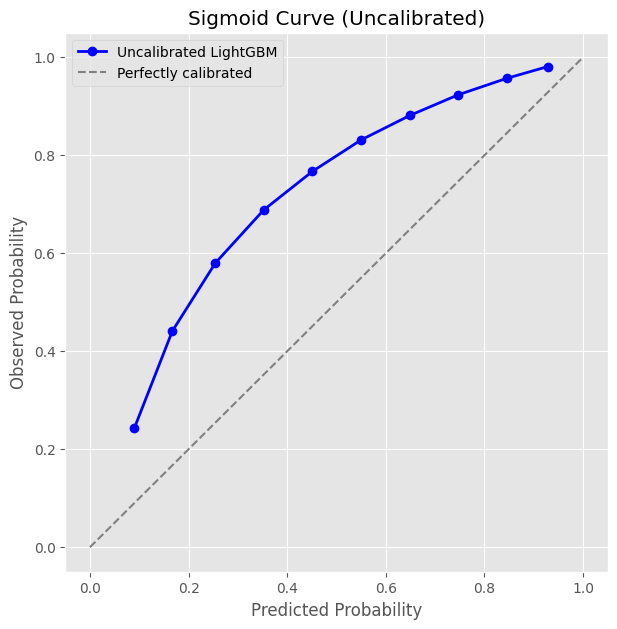

In [45]:
#---Sigmoid Calibration Curve

y_prob_uncal = lgb_best.predict_proba(X2_test)[:, 1]

y_true = Y2_test

prob_true_uncal, prob_pred_uncal = calibration_curve(y_true, y_prob_uncal, n_bins=10, strategy='uniform')

plt.figure(figsize=(7, 7))
plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', linewidth=2, label='Uncalibrated LightGBM', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

plt.title('Sigmoid Curve (Uncalibrated)')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.grid(True)
plt.legend()
plt.show()

In [46]:
#---Fully Interactive Plot of Various Metrics across Thresholds (Uncalibrated)

#Probabilities for positive class
y_prob = lgb_best_test_probs
y_true = Y2_test

#Precompute metrics across thresholds
thresholds = np.linspace(0, 1, 101)
precision_vals, recall_vals, f1_vals = [], [], []
type1_vals, type2_vals = [], []
accuracy_vals = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    
    cm = confusion_matrix(y_true, preds, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    
    precision_vals.append(precision_score(y_true, preds, pos_label=1, zero_division=0))
    recall_vals.append(recall_score(y_true, preds, pos_label=1))
    f1_vals.append(f1_score(y_true, preds, pos_label=1))
    type1_vals.append(FP / (FP + TN) if (FP + TN) > 0 else 0)
    type2_vals.append(FN / (FN + TP) if (FN + TP) > 0 else 0)
    accuracy_vals.append((TP + TN) / (TP + FP + FN + TN))

#Interactive function
def threshold_analysis_with_errors(threshold=0.5):
    preds = (y_prob >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, preds, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Metrics
    precision = precision_score(y_true, preds, pos_label=1, zero_division=0)
    recall    = recall_score(y_true, preds, pos_label=1)
    f1        = f1_score(y_true, preds, pos_label=1)
    accuracy  = (TP + TN) / (TP + TN + FP + FN)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    kappa = cohen_kappa_score(y_true, preds)

    type1_error = FP / (FP + TN) if (FP + TN) > 0 else 0
    type2_error = FN / (FN + TP) if (FN + TP) > 0 else 0

    #Metrics and error plots
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precision_vals, label='Precision', color='blue')
    plt.plot(thresholds, recall_vals, label='Recall', color='green')
    plt.plot(thresholds, f1_vals, label='F1 Score', color='orange')
    plt.plot(thresholds, accuracy_vals, label='Accuracy', color='cyan')
    plt.plot(thresholds, type1_vals, label='Type I Error (FP Rate)', color='red', linestyle='--')
    plt.plot(thresholds, type2_vals, label='Type II Error (FN Rate)', color='purple', linestyle='--')
    plt.axvline(threshold, color='black', linestyle=':', label=f'Selected Threshold={threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score / Error Rate')
    plt.title('Precision, Recall, Accuracy, F1 and Type I/II Errors by Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Confusion matrix heatmap
    annot_labels = np.array([
        [f'{cm_norm[0,0]:.4f}\n(TN={TN:,})', f'{cm_norm[0,1]:.4f}\n(FP={FP:,})'],
        [f'{cm_norm[1,0]:.4f}\n(FN={FN:,})', f'{cm_norm[1,1]:.4f}\n(TP={TP:,})']
    ])
    
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm_norm,
        annot=annot_labels,
        fmt='',
        cmap='Blues',
        xticklabels=['Pred 0 (Rejected)', 'Pred 1 (Accepted)'],
        yticklabels=['Actual 0 (Rejected)', 'Actual 1 (Accepted)'],
        cbar=True
    )

    #Type I Error Label
    ax.text(
        1 + .5, 0 + .3,
        'Type I Error',
        ha='center', va='bottom',
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
    )
    
    #Type II Error Label
    ax.text(
        0 + 0.5, 1 + 0.3,
        'Type II Error',
        ha='center', va='bottom',
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
    )
    plt.title(f'Normalized Confusion Matrix (Threshold={threshold:.2f})')
    plt.show()

    print(f'TN= {TN:,}  FP= {FP:,}')
    print(f'FN= {FN:,}  TP= {TP:,}\n')
    print(f'Accuracy:    {accuracy:.4f}')
    print(f'Precision:   {precision:.4f}')
    print(f'Recall:      {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1 Score:    {f1:.4f}')
    print(f'Kappa:       {kappa:.4f}')
    print(f'Type I Error (FP Rate):  {type1_error:.4f}')
    print(f'Type II Error (FN Rate): {type2_error:.4f}')

#Interactive slider
widgets.interact(threshold_analysis_with_errors, threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Threshold'));

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [17]:
#---Export Rows predicted Positive by model at .75 threshold

#Predicted probabilities
y_prob = lgb_best.predict_proba(X2_test)[:, 1]

#Apply threshold
threshold = 0.75
y_pred = (y_prob >= threshold).astype(int)

#Build full predictions DataFrame
full_predictions = X2_test.copy()
full_predictions['Pred_Prob'] = y_prob
full_predictions['Pred_Label'] = y_pred
full_predictions['Actual_Label'] = Y2_test.values
full_predictions.head()

,Co-Sign,Term,FICO_Score,Employment_Length,Debt-Income,Installment-Income_Monthly,Loan-Income,Existing_LoanBal-Income,MortgageBal-Income,RevolvingBal-Income,Revolving_Util,OnTime_Payment_%,PastDue-Income,Int_Rate,Bankruptcies,Chage-Offs_12m,Collections_12m,Delinquencies_>120days_Ever,Delinquencies_>90days_24m,Delinquent_Accounts,Months_since_Delinquency,Credit_Age_inMonths,Credit_Inquiries_12m,Months_since_Revolver_Issued,Months_since_Prior_Loan_Issued,Revolvers_12m,Prior_Loans_12m,Mortgage_Accounts,Home_Ownership,Loan_Purpose,Pred_Prob,Pred_Label,Actual_Label
1193350,0,0,662,0,10,8,17,37,0,14,74,80,0,21,0,0,0,2,0,0,23,140,1,9,29,2,0,0,RENT,debt_consolidation,0,0,1
136610,0,1,702,10,31,5,19,0,137,83,63,97,0,9,0,0,0,0,0,0,49,490,0,29,999,0,0,4,MORTGAGE,credit_card,1,0,1
12479,0,1,682,9,32,13,36,246,191,10,60,93,0,27,0,0,0,1,0,0,7,185,2,8,13,1,0,2,MORTGAGE,debt_consolidation,0,0,0
245102,0,0,687,2,33,4,10,0,0,55,65,95,0,13,0,0,0,0,0,0,41,146,0,3,999,0,0,0,RENT,debt_consolidation,0,0,1
813069,0,0,692,3,17,8,19,0,389,24,83,93,0,11,0,0,0,0,0,0,12,361,0,3,999,0,0,6,MORTGAGE,credit_card,1,0,1


In [18]:
full_predictions.to_csv('Accepted_Only_Predicted_vs_Actual_Round2.csv', index=False)